# Predicting Seasonal Flu Vaccines
Aung Si

---

## Contents

1. [Data Loading and Cleaning](#exploratory-data-analysis)
    - [Examining Feature Correlations](#examining-feature-correlations)
    - [Handling Nulls](#handling-nulls)
2. [Preparing for Model Building](#preparing-for-model-building)

## Data Loading and Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load in data
train_features = pd.read_csv('data/training_set_features.csv')
train_labels = pd.read_csv('data/training_set_labels.csv')
test_features = pd.read_csv('data/test_set_features.csv')

train_df = pd.merge(train_labels, train_features, on='respondent_id')
train_df.set_index('respondent_id', inplace=True)

In [4]:
# Examine the dataset's shape
print(f'train_df.shape: {train_df.shape}')

train_df.shape: (26707, 37)


In [5]:
# Examine the dataset's datatypes
train_df.dtypes

h1n1_vaccine                     int64
seasonal_vaccine                 int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                     

In [6]:
# Examine the vaccination value counts
for vaccine in ['seasonal_vaccine', 'h1n1_vaccine']:
    print(train_df[vaccine].value_counts())

# Given that seasonal vaccine has a better class balance, we'll choose that as our target

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


### Examining Feature Correlations

Before modeling, we need to check the correlations among our features. In classification as in regressions, this is key. If two features are highly correlated, we might remove one to reduce redundancy. If two features are moderately correlated but convey different information, we might keep both and consider regularization. This step helps avoid issues like noise and overfitting, making the model more robust and interpretable.

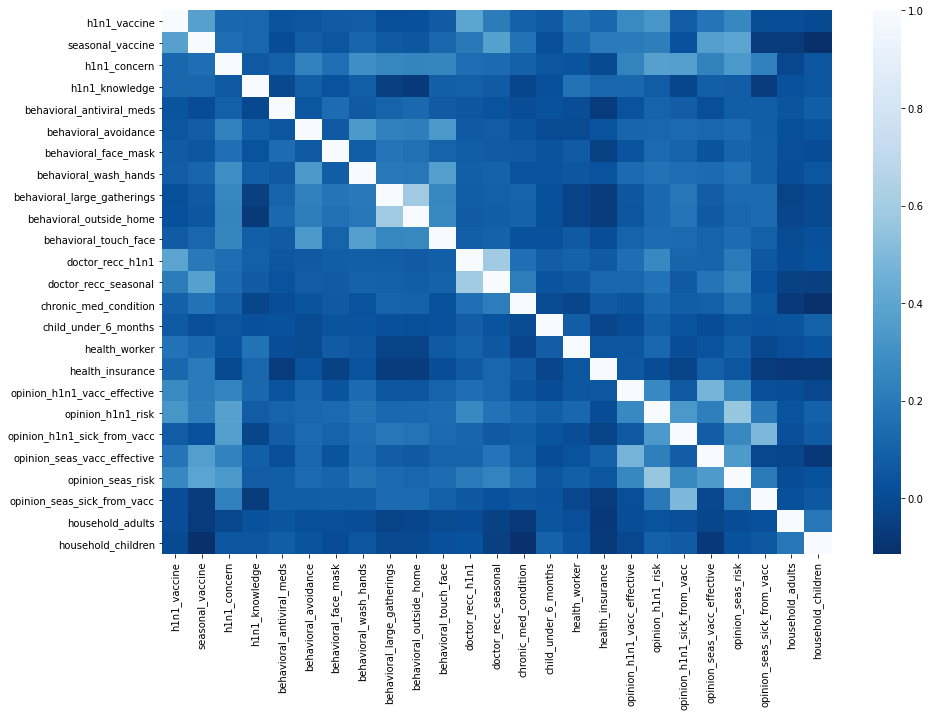

In [7]:
corr_mat = train_df.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_mat, cmap='Blues_r')
plt.show()

Overall, there seems to be moderately positive positive correlations across the features. However, just to be sure, we'll play around with some regularization methods later on to make our models more robust.

### Handling Nulls

In [8]:
train_df.isnull().sum()

h1n1_vaccine                       0
seasonal_vaccine                   0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
i

It seems we have a fair amount of null values within our dataset to handle. It's easy to drop all entries with null values, but this might be reckless. Instead, we'll get rid of features with $>30\%$ null values, unless we deem them important to our analysis.

In [9]:
missing_data = train_df.isnull().sum()
missing_data_pct = missing_data / len(train_df)
missing_data_pct[missing_data_pct > .3]

health_insurance         0.459580
employment_industry      0.499120
employment_occupation    0.504362
dtype: float64

The following features seem to have more than 30% null values:
- `health_insurance` $(46\%)$
- `employment_industry` $(50\%)$
- `employment_occupation` $(50\%)$

The latter two have encoded values that aren't interpretable (nor does the CDC provide instruction on how to decode them), so we'll go ahead and drop those two. For `health_insurance`: health insurance data is usually available for people who have it, so for this analysis we'll replace the `NaN` values with 0s. Essentially, we deem respondents with missing health insurance data as lacking insurance.

In [10]:
train_df['health_insurance'].fillna(0, inplace=True)
train_df.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)
train_df.shape

(26707, 35)

We got rid of two columns, leaving us with 35 columns, down from 37.

### Reconciling Datatypes

From the problem description on Kaggle, we know that the data is mostly categorical data. However, there are still inconsistencies within how these categorical datapoints are represented, so we'll have to address those.

In [11]:
string_representations = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
string_representations

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

The above columns are represented in string format. We'll need to use One Hot Encoding to convert those into floats / integers.

In [12]:
train_df_encoded = pd.get_dummies(train_df, columns=string_representations)
encoded_columns = [col for col in train_df_encoded.columns if any(col.startswith(str_col) for str_col in string_representations)]
train_df_encoded[encoded_columns].dtypes

age_group_18 - 34 Years                     uint8
age_group_35 - 44 Years                     uint8
age_group_45 - 54 Years                     uint8
age_group_55 - 64 Years                     uint8
age_group_65+ Years                         uint8
education_12 Years                          uint8
education_< 12 Years                        uint8
education_College Graduate                  uint8
education_Some College                      uint8
race_Black                                  uint8
race_Hispanic                               uint8
race_Other or Multiple                      uint8
race_White                                  uint8
sex_Female                                  uint8
sex_Male                                    uint8
income_poverty_<= $75,000, Above Poverty    uint8
income_poverty_> $75,000                    uint8
income_poverty_Below Poverty                uint8
marital_status_Married                      uint8
marital_status_Not Married                  uint8


In [13]:
train_df_encoded.shape

(26707, 63)

Now that we've encoded some features, we've almost doubled our feature set - this can lead to even more multicollinearity, which is something we have to be cognizant of when building our models!

## Preparing for Model Building

Before we start building our models, we need to deal with the remaining missing data points. So far, we've only removed features with too many null values. To fill in the rest, we can use `SimpleImputer` from `sklearn.impute`, but we have to be careful: we don't want any data leakage from our validation set. If we were to impute before splitting, information from the validation set could influence the training data. By handling missing values after the split, we ensure a fair and accurate evaluation of our models.

For our train-test splitting, we'll keep $60\%$ of our data as training, and use the remainder $40\%$ as our validation set.

In [14]:
from sklearn.model_selection import train_test_split

target = 'seasonal_vaccine' # We want to predict seasonal vaccine

X = train_df_encoded.drop(columns=target)
y = train_df_encoded[target]

seed = 42 # For reproducability
test_size = .4

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16024, 62), (10683, 62), (16024,), (10683,))

Now that we've split our data, we can use `SimpleImputer`. We'll factor this into a function so we can do this on both the training and validation datasets. Since our data is represented by discrete numerics, we'll use the mode to fill in the null values.

In [15]:
from sklearn.impute import SimpleImputer

def simple_impute(*Xs):
    results = []
    imputer = SimpleImputer(strategy='most_frequent')
    for X in Xs:
        X_imputed = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
        results.append(X_imputed)
    return tuple(results)

In [16]:
X_train, X_test = simple_impute(X_train, X_test)

print(f'Null values in X_train: {X_train.isnull().sum().sum()}')
print(f'Null values in X_test: {X_test.isnull().sum().sum()}')

Null values in X_train: 0
Null values in X_test: 0


We've successfully handled all the missing values in our input datasets - both for training and validation. However, we haven't checked if our target, `y`, has any missing values. Let's quickly do that:

In [17]:
print(f'Null values in y_train: {y_train.isnull().sum().sum()}')
print(f'Null values in y_test: {y_test.isnull().sum().sum()}')

Null values in y_train: 0
Null values in y_test: 0


Great, we have no null values in `y`. We can now get to building our models!

## Building Models

One last thing to address before we dive into modeling - our input features are on different scales. To level the playing field, we'll use `StandardScaler` from sklearn to scale our features uniformly. With that in place, we're ready to build some models to predict whether a respondent gets their seasonal flu vaccine.

We'll kick things off with a simple baseline: a logistic regression model. It's a good starting point, and we'll evaluate it based on accuracy, F1 score, and the ROC curve. From there, we can refine it or explore other models to improve our predictions, and we'll keep at it until we're satisfied with the results.

To streamline this process, we'll bundle these steps into a pipeline. And to keep everything organized, we'll store our pipelines in a dictionary. That way, we can easily track and compare the models we've used. Let's get started with defining a function to create, train, and evaluate different machine learning models within a pipeline structure. This function will allow us to easily compare the performance of different models and detect overfitting or underfitting by comparing training and test scores.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

def run_pipeline(pipeline, stats_df, X_train, X_test, y_train, y_test, index):
    # Fit pipeline
    pipeline.fit(X=X_train, y=y_train)
    
    # Predict and evaluate on training data
    y_train_pred = pipeline.predict(X_train)
    y_train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    
    # Predict and evaluate on test data
    y_test_pred = pipeline.predict(X_test)
    y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    stats = {
        'Name': list(pipeline.named_steps.values())[1],
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train ROC': train_auc,
        'Test ROC': test_auc
    }
    
    stats_df.loc[index] = stats
    return stats_df

pipelines = {}

stats_df = pd.DataFrame({
    'Name': [], 
    'Train Accuracy': [], 'Test Accuracy': [], 
    'Train F1': [], 'Test F1': [],
    'Train ROC': [], 'Test ROC': []
})

stats_df.index.name = 'Model'

### Baseline Model - Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

model_name_1 = 'baseline_model'

base_pipeline = Pipeline([
        ('standard_scaler', StandardScaler()),
        (model_name_1, LogisticRegression(random_state=seed))
    ])

pipelines[model_name_1] = base_pipeline

stats_df = run_pipeline(
    pipelines[model_name_1], 
    stats_df, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    1
)

stats_df

,Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
Model,,,,,,,
1,LogisticRegression(random_state=42),0.796056,0.803426,0.774931,0.781113,0.873949,0.874566


In [20]:
baseline_coefs = pd.DataFrame(
    pipelines[model_name_1].named_steps[model_name_1].coef_, 
    columns=X_train.columns
).T

baseline_coefs = baseline_coefs.rename(
    columns={0: 'Coefficients'}
).sort_values(
    by='Coefficients', ascending=False
)

baseline_coefs[:10]

,Coefficients
h1n1_vaccine,0.796803
doctor_recc_seasonal,0.729769
opinion_seas_risk,0.705558
opinion_seas_vacc_effective,0.658920
age_group_65+ Years,0.381834
health_worker,0.187041
health_insurance,0.112923
chronic_med_condition,0.101178
behavioral_touch_face,0.096323
h1n1_knowledge,0.073921


In [21]:
from sklearn.tree import DecisionTreeClassifier

model_name_2 = 'decision_tree'

dt_pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    (model_name_2, DecisionTreeClassifier(random_state=seed))
])

pipelines[model_name_2] = dt_pipeline

stats_df = run_pipeline(
    pipelines[model_name_2], 
    stats_df, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    2
)

stats_df

,Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
Model,,,,,,,
1,LogisticRegression(random_state=42),0.796056,0.803426,0.774931,0.781113,0.873949,0.874566
2,DecisionTreeClassifier(random_state=42),1.000000,0.709913,1.000000,0.688887,1.000000,0.708727


In [29]:
dt_fi = pd.DataFrame(
    pipelines[model_name_2].named_steps[model_name_2].feature_importances_, 
    index=X_train.columns
)

dt_fi = dt_fi.rename(
    columns={0: 'Importance'}
).sort_values(
    by='Importance', ascending=False
)

dt_fi[:10]

,Importance
opinion_seas_vacc_effective,0.154537
h1n1_vaccine,0.101832
doctor_recc_seasonal,0.062716
opinion_seas_risk,0.048419
opinion_h1n1_vacc_effective,0.027649
age_group_65+ Years,0.026135
doctor_recc_h1n1,0.025659
opinion_h1n1_sick_from_vacc,0.024908
opinion_seas_sick_from_vacc,0.024599
h1n1_concern,0.024494


### Model 3 - Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

model_name_3 = 'rf'

rf_pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    (model_name_3, RandomForestClassifier(random_state=seed))
])

pipelines[model_name_3] = rf_pipeline

stats_df = run_pipeline(pipelines[model_name_3], stats_df, X_train, X_test, y_train, y_test, 3)
stats_df

,Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
Model,,,,,,,
1,LogisticRegression(random_state=42),0.796056,0.803426,0.774931,0.781113,0.873949,0.874566
2,DecisionTreeClassifier(random_state=42),1,0.709913,1,0.688887,1,0.708727
3,"(DecisionTreeClassifier(max_features='auto', r...",1,0.800711,1,0.780809,1,0.873667


In [34]:
rf_fi = pd.DataFrame(
    pipelines[model_name_3].named_steps[model_name_3].feature_importances_,
    index=X_train.columns
)

rf_fi = rf_fi.rename(
    columns={0: 'Importance'}
).sort_values(
    by='Importance', ascending=False
)

rf_fi[:10]

,Importance
opinion_seas_vacc_effective,0.090711
opinion_seas_risk,0.071775
h1n1_vaccine,0.068969
doctor_recc_seasonal,0.064878
opinion_h1n1_risk,0.033056
opinion_h1n1_vacc_effective,0.031778
age_group_65+ Years,0.028270
opinion_seas_sick_from_vacc,0.028237
h1n1_concern,0.027237
opinion_h1n1_sick_from_vacc,0.026104
